## change point & peak 분석

In [1]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import yfinance as yf # yahoo finance API    # pip install yfinance
import investpy # investing.com API          # pip install investpy
from pykrx import stock # krx API           # pip instasll pykrx
import talib as ta # 기술적 분석 (보조지표)
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from datetime import datetime

import seaborn as sns

# 시각화 사용자 설정
from matplotlib import rcParams
sns.set_style('whitegrid')
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import find_peaks

from konlpy.tag import Okt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [3]:
start_date='2020-09-01'
end_date='2021-03-01'


In [4]:
# investing.com 양식, ex) dd/mm/yyyy
start_date_ = start_date[8:] + '/' + start_date[5:7] + '/' + start_date[:4]
end_date_ = end_date[8:] + '/' + end_date[5:7] + '/' + end_date[:4]

# krx 양식 ex) yyyymmdd
start_date__ = start_date[0:4] + start_date[5:7] + start_date[8:10]
end_date__ = end_date[0:4] + end_date[5:7] + end_date[8:10]

In [5]:
model_samsung = pd.DataFrame()
# 삼성 차트 데이터
# 주요 3개국 대비 원 환율

# 달러/원
exchange_rate_usd_ = investpy.get_currency_cross_historical_data(currency_cross='USD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_usd_.columns = ['exchange_rate_usd_Open', 'exchange_rate_usd_High', 'exchange_rate_usd_Low', 'exchange_rate_usd_Close', 'exchange_rate_usd_Currency']
exchange_rate_usd_ = exchange_rate_usd_.drop(['exchange_rate_usd_Open','exchange_rate_usd_High','exchange_rate_usd_Low','exchange_rate_usd_Currency'], axis=1)

# S&P 500
snp_500_ = yf.download("^GSPC", start=start_date, end=end_date)
snp_500_.columns = ['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Close','snp_500_Adj Close','snp_500_Volume']
snp_500_ = snp_500_.drop(['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Adj Close','snp_500_Volume'], axis=1)


# 삼성 차트 데이터
sam_ = stock.get_market_ohlcv_by_date(start_date__, end_date__, "005930")
sam_.columns = ['Open','High','Low','Close','Volume']
model_samsung = sam_.copy()

# SOX 지수 엔비디아(8.9%), 텍사스인스트루먼트(8.6%), 퀄컴(7.7%), 인텔(7.4%) 반도체장비기업 18.52%
SOXX = yf.download("SOXX", start=start_date, end=end_date)
SOXX.columns = ['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Close','SOXX_Adj Close','SOXX_Volume']
SOXX = SOXX.drop(['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Adj Close','SOXX_Volume'], axis=1)
model_samsung['SOXX'] = SOXX
model_samsung['SNP500'] = snp_500_

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
model_samsung = model_samsung.dropna() # 결측치가 있는 행 제거

In [7]:
maxClose = model_samsung['Close'].max()
maxSNP500 = model_samsung['SNP500'].max()
maxSOXX = model_samsung['SOXX'].max()

model_samsung["rev_Close"] = maxClose- model_samsung['Close']
model_samsung["rev_SNP500"] = maxSNP500- model_samsung['SNP500']
model_samsung["rev_SOXX"] = maxSOXX- model_samsung['SOXX']

In [8]:
# 차트 비교분석을 위한 정규화
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(model_samsung)
output = min_max_scaler.transform(model_samsung)
output = pd.DataFrame(output, columns=model_samsung.columns, index=list(model_samsung.index.values))
print(output.head())

                Open      High       Low     Close    Volume      SOXX  \
2020-09-01  0.000000  0.000000  0.000000  0.000000  0.123986  0.171770   
2020-09-02  0.013812  0.007143  0.000000  0.005435  0.093642  0.231436   
2020-09-03  0.041436  0.045238  0.039548  0.059783  0.235388  0.113287   
2020-09-04  0.030387  0.023810  0.028249  0.038043  0.158264  0.092522   
2020-09-08  0.091160  0.092857  0.087571  0.122283  0.274070  0.000000   

              SNP500  rev_Close  rev_SNP500  rev_SOXX  
2020-09-01  0.416476   1.000000    0.583524  0.828230  
2020-09-02  0.494372   0.994565    0.505628  0.768564  
2020-09-03  0.313568   0.940217    0.686432  0.886713  
2020-09-04  0.273175   0.961957    0.726825  0.907478  
2020-09-08  0.136444   0.877717    0.863556  1.000000  


## 삼성전자와 다른 상관관계 변수와의 Peak 비교(SOX, S&P500)


In [42]:
start_date = '2020-11-01'
end_date   = '2021-02-01'

In [43]:
Close_samsung= output['Close'][start_date:end_date]

In [44]:
min_Close_samsung= output['rev_Close'][start_date:end_date]

In [45]:
price_peak_limit = 0.1
peaks, properties = find_peaks(Close_samsung, height=price_peak_limit)

print(f'Index of each peaks : {Close_samsung.index[peaks]}')
print(f'Height of each peaks : {properties["peak_heights"]}')

Index of each peaks : DatetimeIndex(['2020-11-03', '2020-11-05', '2020-11-11', '2020-11-16',
               '2020-11-24', '2020-11-27', '2020-12-07', '2020-12-09',
               '2020-12-15', '2020-12-28', '2021-01-05', '2021-01-11',
               '2021-01-21', '2021-01-25'],
              dtype='datetime64[ns]', freq=None)
Height of each peaks : [0.125      0.16576087 0.19293478 0.32880435 0.36684783 0.38043478
 0.50815217 0.53532609 0.5326087  0.66576087 0.80706522 1.
 0.92119565 0.95652174]


In [46]:
price_peak_limit = 0.1
peaks2, properties2 = find_peaks(min_Close_samsung, height=price_peak_limit)

print(f'Index of each peaks : {min_Close_samsung.index[peaks2]}')
print(f'Height of each peaks : {properties2["peak_heights"]}')

Index of each peaks : DatetimeIndex(['2020-11-04', '2020-11-06', '2020-11-12', '2020-11-19',
               '2020-11-25', '2020-11-30', '2020-12-08', '2020-12-10',
               '2020-12-22', '2020-12-29', '2021-01-06', '2021-01-19',
               '2021-01-22', '2021-01-29'],
              dtype='datetime64[ns]', freq=None)
Height of each peaks : [0.88315217 0.83967391 0.81521739 0.7173913  0.66304348 0.66032609
 0.52445652 0.49184783 0.50815217 0.3451087  0.23913043 0.10869565
 0.11413043 0.24456522]


In [47]:
max_peaks = peaks
min_peaks = peaks2

In [48]:
new_peaks = np.concatenate((peaks, peaks2),axis=0)
new_peaks = np.sort(new_peaks)
new_peaks

array([ 1,  2,  3,  4,  7,  8, 10, 13, 16, 17, 18, 19, 24, 25, 26, 27, 30,
       35, 38, 39, 42, 43, 46, 51, 53, 54, 55, 59], dtype=int64)

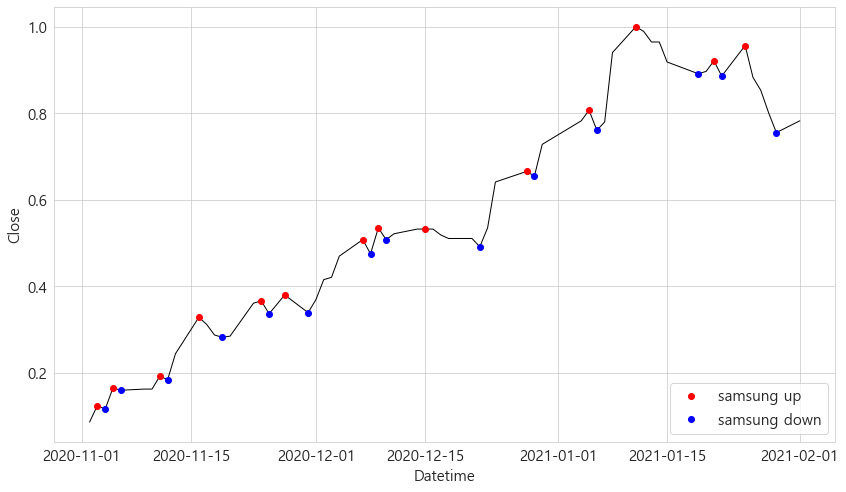

In [49]:
plt.figure(figsize = (14, 8))
plt.plot_date(Close_samsung.index, Close_samsung, 'k-', linewidth = 1)
#plt.plot_date(output['macd'].index, output['macd'], 'g-', linewidth = 1)
plt.plot_date(Close_samsung.index[peaks], Close_samsung[peaks], 'ro', label = 'samsung up')
plt.plot_date(Close_samsung.index[peaks2], Close_samsung[peaks2], 'bo', label = 'samsung down')

plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend(loc = 4)
plt.show()

In [50]:
# max peak와 min peak 찍어보기

In [51]:
Close_SNP500= output['SNP500'][start_date:end_date]
Close_SOXX= output['SOXX'][start_date:end_date]

In [52]:
min_SNP500= output['rev_SNP500'][start_date:end_date]
min_SOXX= output['rev_SOXX'][start_date:end_date]

In [53]:
price_peak_limit = 0.1
peaks3, properties3 = find_peaks(Close_SNP500, height=price_peak_limit)
peaks4, properties4 = find_peaks(Close_SOXX, height=price_peak_limit)

peaks5, properties5 = find_peaks(min_SNP500, height=price_peak_limit)
peaks6, properties6 = find_peaks(min_SOXX, height=price_peak_limit)

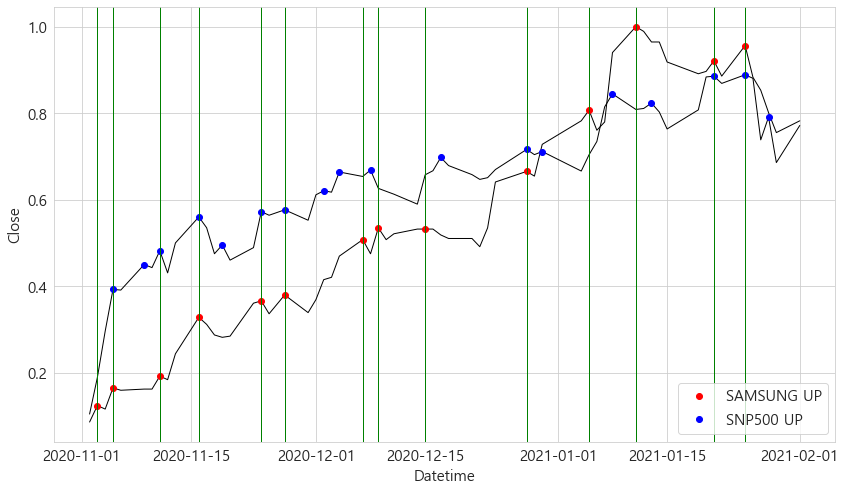

In [54]:
plt.figure(figsize = (14, 8))
plt.plot_date(Close_samsung.index, Close_samsung, 'k-', linewidth = 1)
plt.plot_date(Close_SNP500.index, Close_SNP500, 'k-', linewidth = 1)
plt.plot_date(Close_samsung.index[peaks], Close_samsung[peaks], 'ro', label = 'SAMSUNG UP')
plt.plot_date(Close_SNP500.index[peaks3], Close_SNP500[peaks3], 'bo', label = 'SNP500 UP')

for date in Close_samsung.index[peaks]:
    plt.axvline(x=date, color='g', linestyle='-', linewidth=1)
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend(loc = 4)
plt.show()
# 삼성전자와 S&P500의 MAX PEAK의 비교 -> 어느정도 유사점이 발견

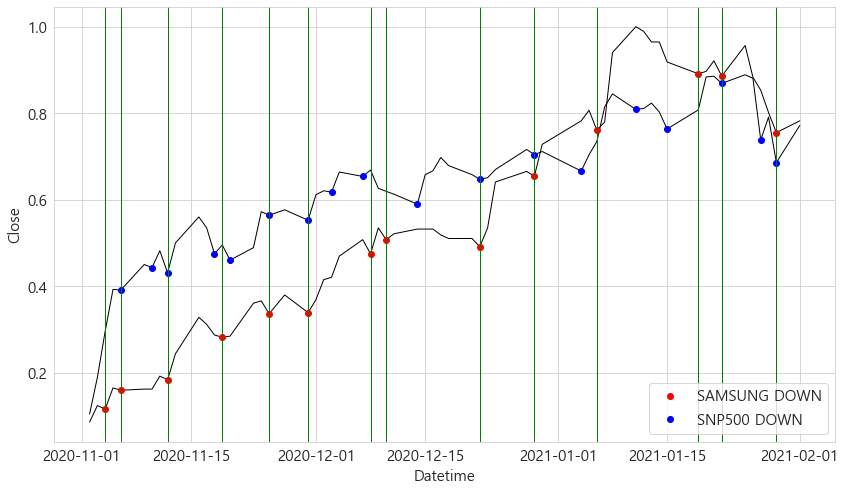

In [55]:
plt.figure(figsize = (14, 8))
plt.plot_date(Close_samsung.index, Close_samsung, 'k-', linewidth = 1)
plt.plot_date(Close_SNP500.index, Close_SNP500, 'k-', linewidth = 1)
plt.plot_date(Close_samsung.index[peaks2], Close_samsung[peaks2], 'ro', label = 'SAMSUNG DOWN')
plt.plot_date(Close_SNP500.index[peaks5], Close_SNP500[peaks5], 'bo', label = 'SNP500 DOWN')

for date in Close_samsung.index[peaks2]:
    plt.axvline(x=date, color='g', linestyle='-', linewidth=1)
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend(loc = 4)
plt.show()
# 삼성전자와 S&P500의 MIN PEAK의 비교 

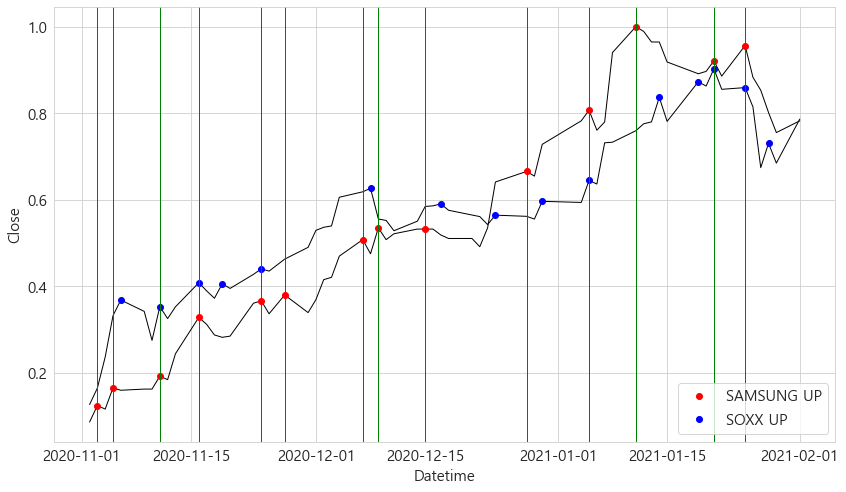

In [56]:
plt.figure(figsize = (14, 8))
plt.plot_date(Close_samsung.index, Close_samsung, 'k-', linewidth = 1)
plt.plot_date(Close_SOXX.index, Close_SOXX, 'k-', linewidth = 1)
plt.plot_date(Close_samsung.index[peaks], Close_samsung[peaks], 'ro', label = 'SAMSUNG UP')
plt.plot_date(Close_SOXX.index[peaks4], Close_SOXX[peaks4], 'bo', label = 'SOXX UP')

for date in Close_samsung.index[peaks]:
    plt.axvline(x=date, color='g', linestyle='-', linewidth=1)
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend(loc = 4)
plt.show()
# 삼성전자와 SOX의 MAX PEAK의 비교 

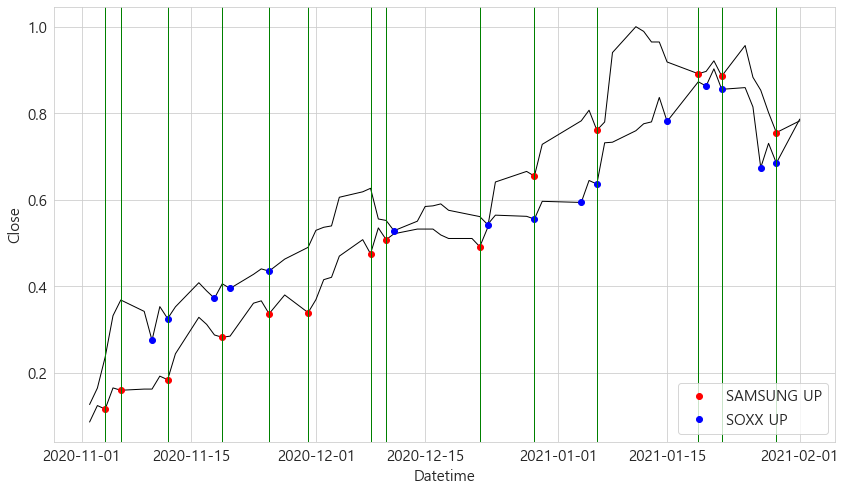

In [57]:
plt.figure(figsize = (14, 8))
plt.plot_date(Close_samsung.index, Close_samsung, 'k-', linewidth = 1)
plt.plot_date(Close_SOXX.index, Close_SOXX, 'k-', linewidth = 1)
plt.plot_date(Close_samsung.index[peaks2], Close_samsung[peaks2], 'ro', label = 'SAMSUNG UP')
plt.plot_date(Close_SOXX.index[peaks6], Close_SOXX[peaks6], 'bo', label = 'SOXX UP')

for date in Close_samsung.index[peaks2]:
    plt.axvline(x=date, color='g', linestyle='-', linewidth=1)
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend(loc = 4)
plt.show()
# 삼성전자와 SOX의 MINX PEAK의 비교 

## Peak 일자별 뉴스기사 크롤링 & 단어 빈도수 TOP10 불러오기

In [25]:
##위에 start_date와 end_date를 좀더 늘려서 해야 정확함.

In [30]:
from bs4 import BeautifulSoup
import requests

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

#뉴스 데이터 가져오기(관련기사는 제거)
def getPageNewsData(page, news_url) :
    url = news_url + "&page=" + str(page)
    response = requests.get(url)
    response.encoding = 'euc-kr' #한글깨짐방지
    soup = BeautifulSoup(response.text, 'html.parser')
    
    table = soup.find('table')
    rlist = table.find_all('tr', class_="relation_lst")
    for tr in rlist :
        tr.decompose()

    df = pd.read_html(str(table), header=0)[0].dropna()
    return df

#마지막 페이지 번호
def getLastPageNum(soup) :
    return int(soup.find("table", class_="Nnavi").find("td", class_="pgRR").find("a").get("href").split("&")[1].split("=")[1])

In [31]:
def getNews(code, startDate) :
    news_url = 'https://finance.naver.com/item/news_news.nhn?code='+code
    #기사 가져오기
    response = requests.get(news_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    #마지막 페이지 가져오기
    last_page = getLastPageNum(soup)

    #페이지별로 loop 돌면서 dataframe으로 만들기
    last_index = last_page+1

    news_df = getPageNewsData(1, news_url).dropna()
    for i in range(2, last_index) :
        tmp_df = getPageNewsData(i, news_url)
        add_df = tmp_df[tmp_df['날짜'] > startDate]
        news_df = pd.concat([news_df, add_df], ignore_index=True)
        if len(add_df) < len(tmp_df) : 
            break

    #추가 : 중복제거
    news_df = news_df.drop_duplicates()

    # 데이터셋으로 쓸 dataframe 만들기
    # 날짜 / 제목 / updown
    news_df['date'] = news_df['날짜'].str.split(' ').str[0]
    pivot_df = news_df.drop(['정보제공', '날짜'], axis=1).rename({'제목':'subject'}, axis='columns')
    pivot_df= pivot_df.reset_index() #중복제거하면 인덱스가 빵구가 나서 인덱스 초기화 후 다시 매꿔주기
    del pivot_df["index"]
    return pivot_df

In [32]:
pivot_df = getNews('005930', '2020.09.01') ## 삼성전자 네이버에서 2020.09.01 이후 기사 가져오기

In [33]:
size = len(pivot_df)
for s in range(size):
    pivot_df['date'][s] = pivot_df['date'][s][0:4]+pivot_df['date'][s][5:7]+pivot_df['date'][s][8:10]
## 뉴스기사의 date 형태를 yyyymmdd로 변경해주기

In [34]:
save_pivot_df = pivot_df

In [35]:
model_samsung = model_samsung.reset_index()

In [36]:
MAX = [] ## 최대치일때의 일자에 대한 뉴스 헤드라인을 넣는다.
MIN = [] ## 최저치일때의 일자에 대한 뉴스 헤드라인을 넣는다.

size = len(save_pivot_df)
for day in max_peaks:
    for s in range(size):
        Sdate = model_samsung['날짜'][day].strftime('%Y%m%d')
        if(save_pivot_df['date'][s]== Sdate):
            print(save_pivot_df['date'][s] + save_pivot_df['subject'][s])
            MAX.append(save_pivot_df['subject'][s])

for day in min_peaks:
    for s in range(size):
        Sdate = model_samsung['날짜'][day].strftime('%Y%m%d')
        if(save_pivot_df['date'][s]== Sdate):
            print(save_pivot_df['date'][s] + save_pivot_df['subject'][s])
            MIN.append(save_pivot_df['subject'][s])

20201105삼성 준법감시위, 삼성전자 등 7개 계열 최고경영진 만나기로
20201105韓 상속세율 OECD 최고수준···삼성, 호주서 상속하면 상속세 '0원...
20201105삼성디스플레이, 인도에 100여명 파견…OLED 공장 막바지 작업
20201105삼성 인공인간 '네온', 신한은행 신입행원 된다(종합)
20201105[단독] 출시 한달만에 200만대…삼성도 놀란 `갤S20 FE` 돌풍
20201105바이든 당선 유력…삼성·LG '화웨이 수출 규제' 풀릴 수 있나
20201105신한은행, 삼성전자 '인공지능 상담 서비스' 제공
20201105오하임아이엔티·삼성머스트스팩3호 합병 승인…12월 '코스닥' 상장
20201105DDR5 시대 개막, 삼성 SK하이닉스에 큰 기회온다
20201105삼성디스플레이, 인도 OLED 공장 셋업 위해 100명 파견
20201105"인공인간 '네온'이 금융상담 해드립니다" 신한銀-삼성전자 맞손
20201105“韓 상속세 부담 OECD 최고”···삼성, 호주서 상속했다면 ‘0원’
20201105뉴아이디, 미국 삼성TV플러스에 채널 론칭
20201105글로벌 1위제품 20개 삼성, 5G시장서 영역 확대
20201105‘스마트싱스 허브’ 국내 판매 시작..한국서는 ‘삼성’ 뗀다
20201105신한은행, '인공인간' 네온 서비스 도입... 삼성전자와 업무협약
20201105신한은행-삼성전자, AI 서비스 개발 손잡았다
20201105삼성 엄정대응, '보암모' 불법시위 회당 140만원 배상금
20201105삼성전자 직원이 딱 1분 만에 "살게요" 찜한 '자석'의 정체
20201111"여성 권익 향상에 기여" 김명자 회장·전영애 교수 '삼성행복대상'
20201111[단독] "SW도 초일류로" 삼성, 품질 상황판 만든다
20201111"공상과학영화 현실로"…네이처 실린 삼성 `홀로그래픽 디스플레이`
20201111[단독]구글이 삼성에 'OS 갑질'…공정위 칼 뺐다
20201111삼성전자 5년 만에 애플 칩 만들까
20201111[마

20210111'미래 가전' 선보인 삼성…AI 오븐이 조리한 음식, 로봇이 나른다 [...
20210111“보다 나은 일상” 삼성전자, AI·IoT 활용 ‘개인 맞춤형 서비스’...
20210111삼성전자, 로봇청소기 ‘제트봇 AI’ 공개…세계 최초 인텔 AI 솔루션...
20210111삼성은 `AI 석학`…LG는 `가상인간`
20210111`10만전자` 삼성, 요리·청소·반려동물 도우미 로봇 내놨다
20210111[CES 2021] 식자재 구입부터 조리까지..'삼성 쿠킹' 나온다
20210111컴퓨터만 인텔?…삼성 로봇청소기도 이제 인텔! [CES 2021]
20210111[CES 2021] 삼성 로봇청소기에 인텔 AI 심었더니
20210111[CES 2021]'로봇' 앞세운 삼성…'롤러블 폰' 기대감 키운 LG
20210111LG '롤러블폰'이 포문 열고 삼성 '갤럭시S21' 대미 장식 [CES...
20210111삼성전자 '꿈의 주식' 되나...현실이 된 '9만전자'
20210111이재용, 삼성준법위 만나 "독립활동 보장"
20210111코스피 수익률 앞지른 삼성 '액티브 ETF'
20210111[CES2021]삼성은 AI석학·LG는 가상인간 연사…"AI가 사람다운...
20210111"일상의 위기극복 기여"…삼성전자가 CES서 공개한 AI·로봇 기술은?
20210111양말·전선 피해서 쓱싹…삼성 선보인 로봇청소기 신기술
20210111승현준 삼성리서치 소장 "모두를 위한 보다 나은 일상 기여할 것"
20210111최후진술 약속 지킨 이재용…삼성준법감시위 면담 정례화
20210111이재용 "삼성준법감시위 독립 활동 보장"…'뉴 삼성' 준법 의지 강조
20210111주식 4.7조 쇼핑한 동학개미…삼성전자 쓸어담았다
20210111전기차 뜨자 폐배터리 시장 급성장…현대차·삼성·LG도 눈독
20210111"삼성전자·현대차 사야해"…바이오주는 일제히 조정
20210111"나만 삼성전자 없어"…'9만전자' 만든 포모(FOMO)족
20210111'9만전자' 안착한 

20201104삼성전자 ‘C랩 인사이드’ 3개 스타트업 추가 지원
20201106내년 TV업계 화두는 '미니 LED'…삼성 vs LG, 격돌 예고
20201106코스피 2400-삼성전자 6만원은 개미들의 단골 매도점?
20201106[은퇴와 투자] 반도체ETF에 삼성전자가 없다고?
20201106[주식 초고수는 지금]'6만원' 깨졌다...삼성전자 저가 매수 나서는 ...
20201106[빅데이터로 본 재테크] 이건희 회장 별세이후…삼성 지배구조 관련주 이...
20201112삼성바이오에피스 "안과질환치료제 임상3상서 오리지널과 동등성 확인"
20201112삼성전자, 최첨단 '5나노 AP'로 중국 시장 공략
20201112'대주주 3%룰' 완화하더라도… 삼성·하이닉스 경영권 방어 취약
20201112中, 삼성전자 전세기 입국 차단
20201112삼성 금융사도 ‘탈석탄’ 선언… 화력발전 투자·보험인수 중단
20201112中, 패스트트랙 중단···삼성 공장 증설 차질빚나
20201112삼성·LG에 꼬리내린 유럽 `특허사냥꾼`
20201112삼성 금융사들 "脫석탄…ESG 경영 동참"
20201112삼성 금융사들도 '脫석탄'...火電투자 올스톱
20201112삼성전자, 포브스 선정'지속가능 ICT 10대 기업'
20201112中삼성 전세기 불허했지만 LG는 떴다…외교부 “신속통로 중단 아냐”(종...
20201112이재용 삼성 부회장, 이건희 별세 후 첫 경영 행보..'디자인 혁명' ...
20201112'3%룰' 완화해도...삼성, 하이닉스 등 경영권 방어 어렵다
20201112‘AI 핵심’ 반도체 극자외선 노광기술 출원, 삼성전자 2위
20201112아버지 별세 후 이재용의 첫 공식 행보는 '新디자인 경영'...삼성전자...
20201112中, 코로나 방역 위해 삼성전자 전세기 2편 취소
20201112中, 코로나 재확산 우려에…삼성 전세기 운항 취소 통보
20201112삼성전자, 포브스 지속가능 10대 기술기업 선정
20201112삼성생명·화재 등 삼성 금융사들 

20210106삼성 '사업지원TF' 감시강화 곧 논의…이건희 차명재산 출연 가능성도
20210106삼성디스플레이, OLED 특허 급증에 특허관련 외부인재 영입
20210106새해에도 '삼성 헬스'로 건강 지키세요
20210106삼성전자 비스포크 냉장고, 하루 1200대 팔렸다
20210106코스피 27% 차지한 `삼성전자 쏠림` 벗어날때
20210106삼성전자 목표가 줄상향...개인 올 매수액 70% 투입
20210106“올해 스마트폰시장 9% 성장…삼성 1위·화웨이 7위”
20210106'삼성의 두뇌' 찾은 이재용…"몇백 배 책임감으로 미래 선점하자"
20210106[단독] `특허 전문가` 김창식 美변호사 삼성디스플레이 구원투수 등판
20210106삼성전자·현대차 외국인 보유율, 아직 코로나 전 수준 회복 못해
20210106"삼성 가전 개인맞춤형 기술 '보다 나은 일상' 만들겠다" ['CES ...
20210106`10만전자` 노리는 삼성 이재용 "몇백배 책임감 가져야"
20210106삼성이 지원한 스타트업 21곳 CES 누빈다
20210106삼성·LG '미니 LED TV' 놓고 각축···LGD, 게임용 벤더블 ...
20210106연초 2.6조 쓸어담은 개미…삼성전자·SK바이오팜 '청신호' [이슈+]
20210106‘이재용의 동행‘ 삼성이 키운 스타트업 21곳 CES 2021 참가
20210106[CES 2021]승현준 삼성리서치 소장 "개인맞춤형·AI 기술, 미래...
20210106삼성 이재용, 삼성리서치 찾아 미래 중장기 전략 점검
20210106삼성전자 ‘비스포크’ 누적 출하량 100만대 넘어섰다
20210106삼성, 역대급 스타트업 ‘CES 2021’ 참가 지원
20210106삼성 ‘비스포크’ 가전 출하량 100만대 돌파
20210106삼성이 키운 스타트업 21개..CES로 세계시장 데뷔
20210106[단독]이재용 삼성 부회장, 수원 찾아 차세대 이동통신 사업 점검
20210106울트라가 플러스보다 싸다?…갤S20 '재고떨이' 나선 삼성
202

20210218금호석화, 경영권 분쟁 ‘조카의 난’ 본격화.. 삼성전자, 총수 부재 ...
20210218코로나 백신 K-주사기, 뒤에는 삼성 '총력 지원' 있었다
20210218일본도 실패한 '쥐어짜기' 주사기 대량 생산···삼성이 도와 가능했다
20210218문 대통령 찾은 백신 주사기 업체···삼성 지원에 생산 성공
20210218삼성, 흩어진 빅데이터 조직 'CEO 직속' 통합
20210218삼성전자, '셧다운' 美 오스틴 반도체 공장에 기술진 파견
20210218키오스크, VR 등 미래사업 보폭넓히는 삼성전자
20210218삼성전자, 내달 2일 '언박스·디스커버리' 개최…TV 신제품 소개
20210218'환골탈태' NEW, OTT와 삼성·LG스마트TV로 글로벌 안방 공략
20210218올해도 TV호황? 베일벗는 삼성 네오QLED vs LG 올레드
20210218삼성, 구형폰에 '갤S21' 최신 기능 담긴 '원 UI 3.1' 업데이...
20210218삼성전자, 셧다운 美 반도체 공장에 기술진 파견
20210218지난해 국내 스마트폰 삼성 점유율 65%…가성비폰 '잘나가'
20210218삼성 '연봉 50% 성과급' 챙기더니…경영진 연봉도 '10억+α' 더 ...
20210218툴젠, 삼성전자 상무 출신 특허전문가 김유리 변리사 영입
20210223삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
20210223삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
20210223삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
20210223삼성전자 '5000만 화소 이미지센서'로 소니 잡는다
20210223글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
20210223움직이는 물체도 선명하게 찰칵! 삼성전자, 폰카메라 초점 신기술
2021022310만전자 바라보던 삼성전자, 8만원서 박스권에 갇힌 이유
20210223삼성, 5000만 화소 이미지센서 신제품 출시
20210223삼성, 아이폰 대항력 강화…보안 업데이트 최소

In [37]:
MIN

['삼성전자 ‘C랩 인사이드’ 3개 스타트업 추가 지원',
 "내년 TV업계 화두는 '미니 LED'…삼성 vs LG, 격돌 예고",
 '코스피 2400-삼성전자 6만원은 개미들의 단골 매도점?',
 '[은퇴와 투자] 반도체ETF에 삼성전자가 없다고?',
 "[주식 초고수는 지금]'6만원' 깨졌다...삼성전자 저가 매수 나서는 ...",
 '[빅데이터로 본 재테크] 이건희 회장 별세이후…삼성 지배구조 관련주 이...',
 '삼성바이오에피스 "안과질환치료제 임상3상서 오리지널과 동등성 확인"',
 "삼성전자, 최첨단 '5나노 AP'로 중국 시장 공략",
 "'대주주 3%룰' 완화하더라도… 삼성·하이닉스 경영권 방어 취약",
 '中, 삼성전자 전세기 입국 차단',
 '삼성 금융사도 ‘탈석탄’ 선언… 화력발전 투자·보험인수 중단',
 '中, 패스트트랙 중단···삼성 공장 증설 차질빚나',
 '삼성·LG에 꼬리내린 유럽 `특허사냥꾼`',
 '삼성 금융사들 "脫석탄…ESG 경영 동참"',
 "삼성 금융사들도 '脫석탄'...火電투자 올스톱",
 "삼성전자, 포브스 선정'지속가능 ICT 10대 기업'",
 '中삼성 전세기 불허했지만 LG는 떴다…외교부 “신속통로 중단 아냐”(종...',
 "이재용 삼성 부회장, 이건희 별세 후 첫 경영 행보..'디자인 혁명' ...",
 "'3%룰' 완화해도...삼성, 하이닉스 등 경영권 방어 어렵다",
 '‘AI 핵심’ 반도체 극자외선 노광기술 출원, 삼성전자 2위',
 "아버지 별세 후 이재용의 첫 공식 행보는 '新디자인 경영'...삼성전자...",
 '中, 코로나 방역 위해 삼성전자 전세기 2편 취소',
 '中, 코로나 재확산 우려에…삼성 전세기 운항 취소 통보',
 '삼성전자, 포브스 지속가능 10대 기술기업 선정',
 '삼성생명·화재 등 삼성 금융사들 `탈석탄` 선언…"투자·보험인수 중단"',
 '삼성금융 ‘脫석탄 금융’ 선언…투자·융자·보험인수 등 금지',
 '삼성 금융사도 ‘탈석탄’ 선언···투자·보험인수 중단',
 '8년 만에

In [38]:
MAX

['삼성 준법감시위, 삼성전자 등 7개 계열 최고경영진 만나기로',
 "韓 상속세율 OECD 최고수준···삼성, 호주서 상속하면 상속세 '0원...",
 '삼성디스플레이, 인도에 100여명 파견…OLED 공장 막바지 작업',
 "삼성 인공인간 '네온', 신한은행 신입행원 된다(종합)",
 '[단독] 출시 한달만에 200만대…삼성도 놀란 `갤S20 FE` 돌풍',
 "바이든 당선 유력…삼성·LG '화웨이 수출 규제' 풀릴 수 있나",
 "신한은행, 삼성전자 '인공지능 상담 서비스' 제공",
 "오하임아이엔티·삼성머스트스팩3호 합병 승인…12월 '코스닥' 상장",
 'DDR5 시대 개막, 삼성 SK하이닉스에 큰 기회온다',
 '삼성디스플레이, 인도 OLED 공장 셋업 위해 100명 파견',
 '"인공인간 \'네온\'이 금융상담 해드립니다" 신한銀-삼성전자 맞손',
 '“韓 상속세 부담 OECD 최고”···삼성, 호주서 상속했다면 ‘0원’',
 '뉴아이디, 미국 삼성TV플러스에 채널 론칭',
 '글로벌 1위제품 20개 삼성, 5G시장서 영역 확대',
 '‘스마트싱스 허브’ 국내 판매 시작..한국서는 ‘삼성’ 뗀다',
 "신한은행, '인공인간' 네온 서비스 도입... 삼성전자와 업무협약",
 '신한은행-삼성전자, AI 서비스 개발 손잡았다',
 "삼성 엄정대응, '보암모' 불법시위 회당 140만원 배상금",
 '삼성전자 직원이 딱 1분 만에 "살게요" 찜한 \'자석\'의 정체',
 '"여성 권익 향상에 기여" 김명자 회장·전영애 교수 \'삼성행복대상\'',
 '[단독] "SW도 초일류로" 삼성, 품질 상황판 만든다',
 '"공상과학영화 현실로"…네이처 실린 삼성 `홀로그래픽 디스플레이`',
 "[단독]구글이 삼성에 'OS 갑질'…공정위 칼 뺐다",
 '삼성전자 5년 만에 애플 칩 만들까',
 '[마켓인사이트]삼성넥스트, 인텔 퀄컴과 이스라엘 5G 스타트업에 공동 ...',
 '한국투자증권, 삼성그룹 핵심 기업 투자 랩 출시',
 '매달 100주씩 매수…삼성전자 사외이

In [39]:
okt = Okt()
sub_MAX_set = []
sub_MIN_set = []

def clean(sub) :
    text = re.sub("[^ㄱ-ㅣ가-힣]", " ", sub)
    text2 = text.split()
    #text3 = [w for w in text2 if not w in stopwords]
    return text2

for i in range(0, len(MAX)) :
    sub_MAX_set.append(" ".join(clean(MAX[i])))

for i in range(0, len(MIN)) :
    sub_MIN_set.append(" ".join(clean(MIN[i])))

sub_MAX_set_ml = [" ".join(okt.nouns(sub)) for sub in sub_MAX_set]
sub_MAX_set_dl = [okt.nouns(sub) for sub in sub_MAX_set]

sub_MIN_set_ml = [" ".join(okt.nouns(sub)) for sub in sub_MIN_set]
sub_MIN_set_dl = [okt.nouns(sub) for sub in sub_MIN_set]

vectorizer = CountVectorizer()
# Train_set
MAX_data_features = vectorizer.fit_transform(sub_MAX_set_ml)
np.asarray(MAX_data_features)

MIN_data_features = vectorizer.fit_transform(sub_MIN_set_ml)
np.asarray(MIN_data_features)

array(<445x1047 sparse matrix of type '<class 'numpy.int64'>'
	with 3113 stored elements in Compressed Sparse Row format>, dtype=object)

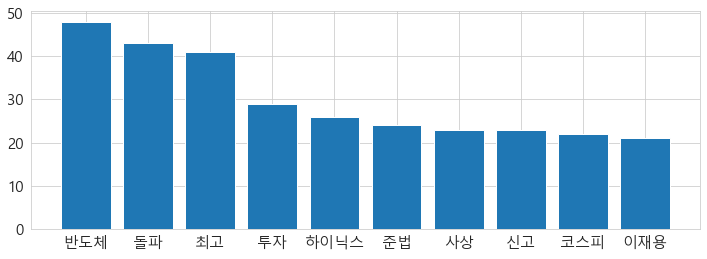

[('반도체', 48), ('돌파', 43), ('최고', 41), ('투자', 29), ('하이닉스', 26), ('준법', 24), ('사상', 23), ('신고', 23), ('코스피', 22), ('이재용', 21)]


In [40]:
tokens = []
for news_tit in sub_MAX_set_ml:
    word = news_tit.split()
    tokens.extend(word)

for a in tokens[::-1]:
    if (a.find('삼성') and a.find('전자') and a.find('만') and a.find('주') and a.find('위')and a.find('장')and a.find('명')
       and a.find('년') and a.find('특징')and a.find('조')) > -1:
        tokens.remove(a)

counted_tokens = Counter(tokens)
top_10 = counted_tokens.most_common(10)


plt.rc('font', family='Malgun Gothic', size=15)
plt.subplots(figsize=(12,4))
plt.bar(*zip(*top_10))
plt.show()
print(top_10)
## 최대치 PEAK일 떄 많이 나오는 단어들
# 의미있는 단어로는 [반도체], [돌파], [최고], [하이닉스], [코스피] 등

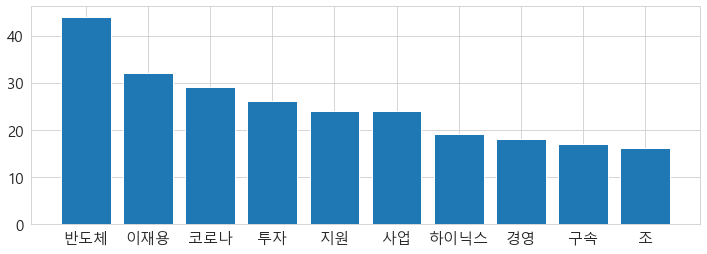

[('반도체', 44), ('이재용', 32), ('코로나', 29), ('투자', 26), ('지원', 24), ('사업', 24), ('하이닉스', 19), ('경영', 18), ('구속', 17), ('조', 16)]


In [41]:
tokens = []
for news_tit in sub_MIN_set_ml:
    word = news_tit.split()
    tokens.extend(word)

for a in tokens[::-1]:
    if (a.find('삼성') and a.find('전자') and a.find('만') and a.find('주') and a.find('위')and a.find('장')and a.find('명')
       and a.find('년') and a.find('특징')) > -1:
        tokens.remove(a)
    
counted_tokens = Counter(tokens)
top_10 = counted_tokens.most_common(10)

plt.rc('font', family='Malgun Gothic', size=15)
plt.subplots(figsize=(12,4))
plt.bar(*zip(*top_10))
plt.show()
print(top_10)
## 최저치 PEAK일 떄 많이 나오는 단어들
## 의미있는 단어로는 [이재용], [코로나], [구속]
## 위 MAX, MIN의 공통점으로 반도체, 하이닉스가 있어 의미가 있다.